proposed method

In [1]:
import numpy as np
import cv2
import os

from sporco import linalg, util, metric, plot
from sporco.dictlrn import cbpdndl
from sporco.admm import cbpdn

from sklearn import metrics
from sklearn.cluster import KMeans
from SF_KMeans import *

from skimage import measure

from torchvision import transforms

def make_option():
    opt = {}
    opt['train_amount'] = 500
    opt['test_amount'] = 500
    return opt

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import random

def load_oranges_data(train_amount, test_amount):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    
    data_path = "data"
    categories = ["freshoranges", "rottenoranges"]
    for i, category in enumerate(categories):
        folder_path = os.path.join(data_path, category)
        file_names = os.listdir(folder_path)
        random.shuffle(file_names)  # randomly shuffle the list of file names
        for j, file_name in enumerate(file_names):
            file_path = os.path.join(folder_path, file_name)
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (28, 28))
            img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0)
            img = img.astype(float) / 255
            if j < train_amount and train_labels.count(i) < train_amount // 2:
                train_data.append(img)
                train_labels.append(i)
            elif j < train_amount + test_amount and test_labels.count(i) < test_amount // 2:
                test_data.append(img)
                test_labels.append(i)
            elif train_labels.count(i) >= train_amount // 2 and test_labels.count(i) >= test_amount // 2:
                break
                
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)




In [3]:
opt = make_option()
train_data, train_label, test_data, test_label = load_oranges_data(opt['train_amount'], opt['test_amount'])

train_data = train_data.transpose(1, 2, 0)
test_data = test_data.transpose(1, 2, 0)

X = train_data
X = X.transpose(2, 0, 1)
X = X.reshape(len(X), -1)
X = X.astype(float) / 255

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  9.90e+04  9.18e+04  1.43e+04  3.62e-16  6.07e-01  5.46e-01  2.55e+01  5.17e-01  2.23e-01  1.00e+01
   1  9.66e+04  9.05e+04  1.23e+04  3.34e-16  3.67e-01  7.38e-01  2.55e+01  3.48e-01  1.97e-01  1.00e+01
   2  9.09e+04  8.31e+04  1.55e+04  4.38e-16  2.08e-01  6.95e-01  2.55e+01  4.03e-01  1.24e-01  1.00e+01
   3  8.85e+04  7.88e+04  1.93e+04  3.59e-16  1.35e-01  4.79e-01  2.55e+01  2.78e-01  5.93e-02  1.00e+01
   4  8.66e+04  7.68e+04  1.97e+04  1.98e-16  7.35e-02  2.71e-01  2.55e+01  2.28e-01  3.37e-02  1.00e+01
   5  8.62e+04  7.61e+04  2.02e+04  3.69e-16  5.66e-02  2.04e-01  2.55e+01  1.63e-01  2.10e-02  1.00e+01
   6  8.57e+04  7.57e+04  2.00e+04  3.85e-16  4.43e-02  1.75e-01  2.55e+01  1.43e-01  1.61e-02  1.00e+01
   7  8.55e+04  7.54e+04  2.01e+04  4.38e-16  3.87e-02 

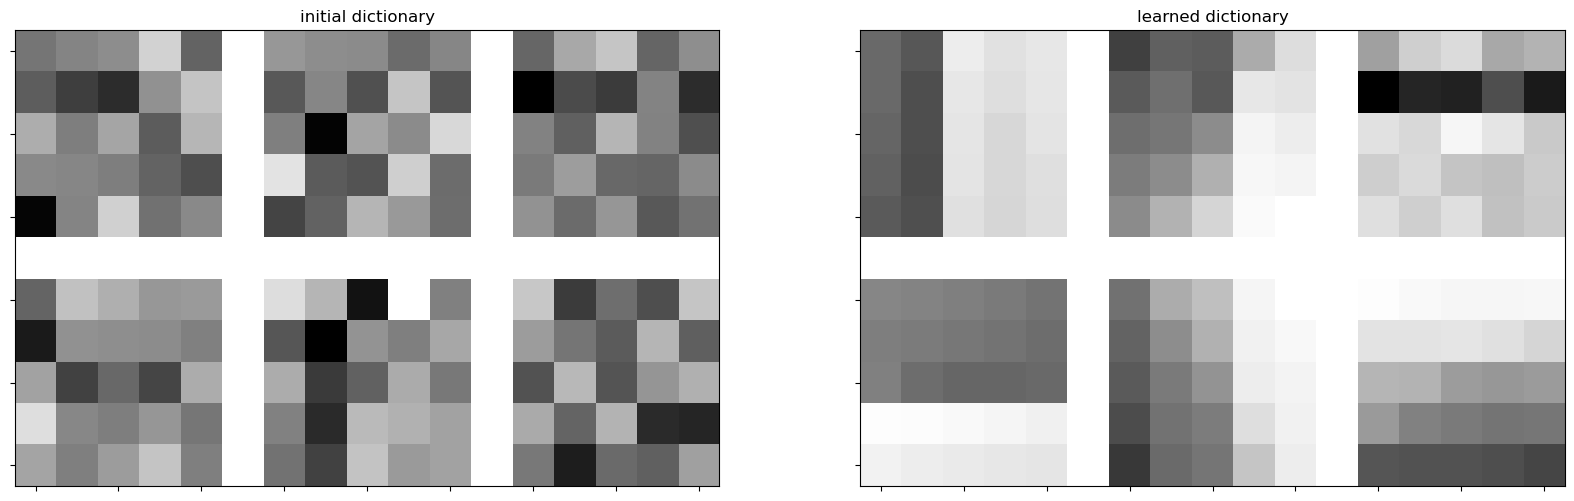

In [4]:
# first CDL layer

from sporco.dictlrn import cbpdndl;

np.random.seed(12345);
#define size of filters ---> (x,y,channel)
D0 = np.random.randn(5, 5, 6);

#execute dictionary learning
lmbda = 0.5;
opt = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True, 'MaxMainIter': 50,
                            'CBPDN': {'rho': 50.0*lmbda + 0.5},
                            'CCMOD': {'rho': 10.0, 'ZeroMean': True}},
                            dmethod='cns');
d = cbpdndl.ConvBPDNDictLearn(D0, train_data, lmbda, opt, dmethod='cns');
#get dictionary(filters)
D1 = d.solve();
print("ConvBPDNDictLearn solve time: %.2fs" % d.timer.elapsed('solve'));

#compare trained filters with original
fig =  plot.figure(figsize=(20, 10));
ax1 = fig.add_subplot(121);
ax2 = fig.add_subplot(122);
plot.imview(util.tiledict(D0), fig=fig, ax=ax1, title="initial dictionary");
plot.imview(util.tiledict(D1.squeeze()), fig=fig, ax=ax2, title="learned dictionary");

#coef ---> sparse feature maps(x, y, number of filters, channel)
coef = np.array(d.getcoef().squeeze());

In [5]:
coef = np.array(d.getcoef().squeeze())

In [6]:
# second CDL layer

from sporco.dictlrn import cbpdndl;

np.random.seed(12345);
#channel in second layer is same as output of first layer
D0 = np.random.randn(5, 5, 6, 16)

lmbda = 0.02;
opt = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True, 'MaxMainIter': 50,
                            'CBPDN': {'rho': 50.0*lmbda + 0.5},
                            'CCMOD': {'rho': 10.0, 'ZeroMean': True}},
                            dmethod='cns');
#input is output of first layer
d = cbpdndl.ConvBPDNDictLearn(D0, coef.transpose(0,1,3,2), lmbda, opt, dmethod='cns');
D2 = d.solve();
print("ConvBPDNDictLearn solve time: %.2fs" % d.timer.elapsed('solve'));


coef2 = np.array(d.getcoef().squeeze());

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  1.43e+03  5.52e+02  4.41e+04  7.23e-16  4.35e-01  1.04e+00  1.50e+00  1.08e-01  2.53e-01  1.00e+01
   1  1.31e+03  5.26e+02  3.92e+04  8.78e-16  2.23e-01  4.93e-01  1.50e+00  7.55e-02  2.78e-01  1.00e+01
   2  1.14e+03  3.82e+02  3.78e+04  9.62e-16  1.34e-01  2.83e-01  1.50e+00  6.36e-02  2.91e-01  1.00e+01
   3  1.06e+03  3.53e+02  3.55e+04  1.05e-15  9.71e-02  2.06e-01  1.50e+00  4.90e-02  2.49e-01  1.00e+01
   4  9.90e+02  3.18e+02  3.36e+04  9.75e-16  7.37e-02  1.60e-01  1.50e+00  4.11e-02  2.52e-01  1.00e+01
   5  9.48e+02  3.03e+02  3.22e+04  9.47e-16  5.98e-02  1.32e-01  1.50e+00  3.24e-02  2.22e-01  1.00e+01
   6  9.07e+02  2.88e+02  3.10e+04  9.31e-16  4.87e-02  1.13e-01  1.50e+00  2.69e-02  2.21e-01  1.00e+01
   7  8.79e+02  2.78e+02  3.00e+04  8.11e-16  4.14e-02 

In [7]:
train_data, train_label, test_data, test_label = load_oranges_data(500, 500)

train_data = train_data.transpose(1, 2, 0)
test_data = test_data.transpose(1, 2, 0)
from sporco.admm import cbpdn

#coefficient maps estimation
#first layer
lmbda = 5e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                              'RelStopTol': 5e-3, 'AuxVarObj': False})

print ('D1 ='+str(D1.shape)+'D2='+str(D2.shape))
b1 = cbpdn.ConvBPDN(D1, train_data, lmbda, opt, dimK=0)
#get coefficient maps
X1 = b1.solve()
X1 = X1.squeeze()
print ('Train_Data='+str(train_data.shape)+'X1='+str(X1.shape))
print("ConvBPDN solve time: %.2fs" % b1.timer.elapsed('solve'))

D1 =(5, 5, 1, 1, 6)D2=(5, 5, 6, 1, 16)
Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  7.01e+04  6.66e+04  6.98e+04  3.66e-01  3.86e+00  3.50e+00
   1  6.85e+04  6.41e+04  8.84e+04  1.70e-01  1.32e+00  3.50e+00
   2  6.88e+04  6.39e+04  9.92e+04  2.50e-01  4.82e-01  1.06e+00
   3  6.90e+04  6.37e+04  1.07e+05  2.72e-01  2.84e-01  6.40e-01
   4  6.88e+04  6.36e+04  1.04e+05  2.45e-01  1.99e-01  5.26e-01
   5  6.85e+04  6.36e+04  9.78e+04  1.86e-01  1.52e-01  5.26e-01
   6  6.82e+04  6.36e+04  9.28e+04  1.46e-01  1.24e-01  5.26e-01
   7  6.80e+04  6.36e+04  8.97e+04  1.27e-01  1.03e-01  4.78e-01
   8  6.79e+04  6.36e+04  8.61e+04  1.01e-01  8.63e-02  4.78e-01
   9  6.78e+04  6.36e+04  8.46e+04  8.81e-02  7.45e-02  4.35e-01
  10  6.77e+04  6.35e+04  8.22e+04  7.14e-02  6.38e-02  4.35e-01
  11  6.76e+04  6.35e+04  8.10e+04  6.45e-02  5.56e-02  3.86e-01
  12  6.75e+04  6.35e+04  8.00e+04  5.77e-02  4.79e

In [8]:
from skimage import measure



test = measure.block_reduce(X1, (4,4,1,1), np.max)
test.shape

(8, 8, 500, 6)

train SVM with exstracted features

exstract features from trained dictionary

In [9]:
# second layer
lmbda = 1e-1
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                              'RelStopTol': 5e-3, 'AuxVarObj': False})

b2 = cbpdn.ConvBPDN(D2.squeeze(), test.transpose(0,1,3,2), lmbda, opt)
X2 = b2.solve()
X2 = X2.squeeze()
print("ConvBPDN solve time: %.2fs" % b2.timer.elapsed('solve'))


Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  2.24e+03  1.50e+03  7.39e+03  3.34e-01  1.70e+00  6.00e+00
   1  2.07e+03  1.26e+03  8.10e+03  1.74e-01  7.18e-01  6.00e+00
   2  2.09e+03  1.13e+03  9.69e+03  2.40e-01  3.78e-01  2.09e+00
   3  2.19e+03  1.08e+03  1.11e+04  2.54e-01  2.12e-01  1.17e+00
   4  2.15e+03  1.05e+03  1.11e+04  2.30e-01  1.19e-01  9.09e-01
   5  2.06e+03  1.05e+03  1.01e+04  1.75e-01  7.40e-02  9.09e-01
   6  1.99e+03  1.05e+03  9.47e+03  1.36e-01  5.17e-02  9.09e-01
   7  1.92e+03  1.05e+03  8.78e+03  9.36e-02  3.73e-02  1.04e+00
   8  1.88e+03  1.05e+03  8.30e+03  6.61e-02  2.85e-02  1.17e+00
   9  1.85e+03  1.05e+03  8.06e+03  5.23e-02  2.15e-02  1.17e+00
  10  1.83e+03  1.05e+03  7.81e+03  3.77e-02  1.58e-02  1.29e+00
  11  1.81e+03  1.05e+03  7.68e+03  3.00e-02  1.20e-02  1.29e+00
  12  1.80e+03  1.05e+03  7.53e+03  2.14e-02  9.21e-03  1.44e+00
  13  1.79e+03  1.05e+03 

In [10]:

def clust_stats(cluster):
    class_freq = np.zeros(10)
    for i in range(10):
        class_freq[i] = np.count_nonzero(cluster == i)
    most_freq = np.argmax(class_freq)
    n_majority = np.max(class_freq)
    n_all = np.sum(class_freq)
    return (n_majority, n_all, most_freq)
    
def clusters_purity(clusters_stats):
    majority_sum  = clusters_stats[:,0].sum()
    n = clusters_stats[:,1].sum()
    return majority_sum / n

def clusters_stats(predict, y):
    stats = np.zeros((10,3))
    for i in range(10):
        indices = np.where(predict == i)
        cluster = y[indices]
        stats[i,:] = clust_stats(cluster)
    return stats

In [16]:

X1_test = X1
X1_test = X1_test.transpose(2,0,1,3)
X1_test = X1_test.reshape(len(X1_test),-1)
X1_test = X1_test.astype(float) / 255



X2_test = X2
X2_test = X2_test.transpose(2,0,1,3)
X2_test = X2_test.reshape(len(X2_test),-1)
X2_test = X2_test.astype(float) / 255

Y = train_label







X = train_data
X = X.transpose(2,0,1)
X = X.reshape(len(X),-1)
X = X.astype(float) / 255


print ('X1_test.shape : '+ str(X1_test.shape))
print ('X2_test.shape : '+ str(X2_test.shape))
print ('X (Original Shape) : '+ str(X.shape))




X1_test.shape : (500, 6144)
X2_test.shape : (500, 1024)
X (Original Shape) : (500, 1024)


In [12]:
# test the infer_cluster_labels() and infer_data_labels() functions
#After First Layer, Reconstructing the First Coefficient.
from sklearn import metrics
from sklearn.cluster import KMeans
from SF_KMeans import *


kmeans_mahalanobis = SF_KMeans(n_clusters = 10)



# initialize and fit KMeans algorithm on training data
#first layer accuracy
kmeans = KMeans(init= 'k-means++',n_clusters = 10, random_state=1,max_iter = 10)



[K-Means using Euclidean Labels]: Purity=0.5 Rand Index: -0.001686205235265778

[K-Means using Mahalanobis Labels]: Purity=0.506 Rand Index: -0.0015223726634028582


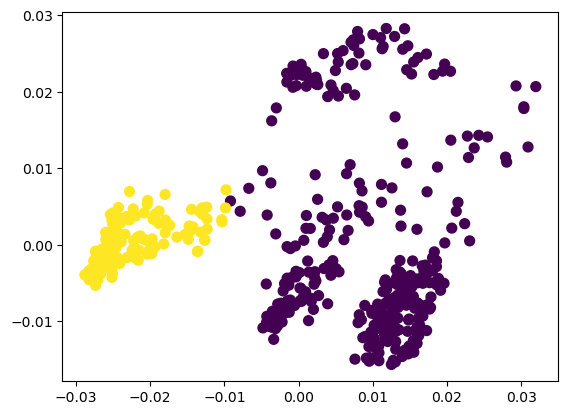

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init= 'k-means++',n_clusters = 2, random_state=0)
kmeans.fit(reduced_data)


kmeans_mahalanobis = SF_KMeans(n_clusters = 2)


centroids = kmeans.cluster_centers_
kmeans_mahalanobis.fit(reduced_data, centroids)


stats = clusters_stats(kmeans.labels_, Y)
purity = clusters_purity(stats)

print ('[K-Means using Euclidean Labels]: Purity=' +str(purity)+ ' Rand Index: ' + str(metrics.adjusted_rand_score(Y, kmeans.labels_)) + '\n')


stats = clusters_stats(kmeans_mahalanobis.labels_, Y)
purity = clusters_purity(stats)

print ('[K-Means using Mahalanobis Labels]: Purity=' +str(purity)+ ' Rand Index: ' + str(metrics.adjusted_rand_score(Y, kmeans_mahalanobis.labels_)))


plt.scatter(reduced_data[:,0],reduced_data[:,1],c =kmeans_mahalanobis.labels_,s=50, cmap='viridis')








test trained dictionary with test data

[K-Means using Euclidean Labels]: Purity=0.566 Rand Index: 0.003116154135445148

[K-Means using Mahalanobis Labels]: Purity=0.572 Rand Index: 0.003267978377393332


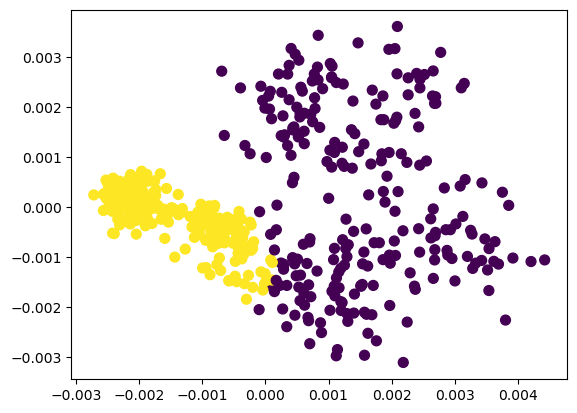

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(X2_test)
kmeans = KMeans(init= 'k-means++',n_clusters = 10, random_state=0)
kmeans.fit(reduced_data)


kmeans_mahalanobis = SF_KMeans(n_clusters = 10)


centroids = kmeans.cluster_centers_
kmeans_mahalanobis.fit(reduced_data, centroids)

stats = clusters_stats(kmeans.labels_, Y)
purity = clusters_purity(stats)
print ('[K-Means using Euclidean Labels]: Purity=' +str(purity)+ ' Rand Index: ' + str(metrics.adjusted_rand_score(Y, kmeans.labels_)) + '\n')


stats = clusters_stats(kmeans_mahalanobis.labels_, Y)
purity = clusters_purity(stats)
print ('[K-Means using Mahalanobis Labels]: Purity=' +str(purity)+ ' Rand Index: ' + str(metrics.adjusted_rand_score(Y, kmeans_mahalanobis.labels_)))





kmeans = KMeans(init= 'k-means++',n_clusters = 2, random_state=0)
kmeans.fit(reduced_data)


kmeans_mahalanobis = SF_KMeans(n_clusters = 2)


centroids = kmeans.cluster_centers_
kmeans_mahalanobis.fit(reduced_data, centroids)


plt.scatter(reduced_data[:,0],reduced_data[:,1],c =kmeans_mahalanobis.labels_,s=50, cmap='viridis')







C:\Users\marcu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


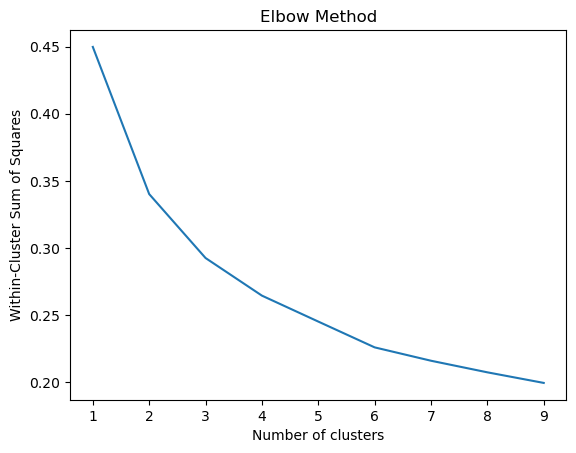

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# X is the data matrix of shape (n_samples, n_features)

wcss = []  # within-cluster sum of squares
for i in range(1, 10):  # try different numbers of clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # save the WCSS

# plot the WCSS vs. number of clusters
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.show()
